# Customer Segmentation

#### By: Brian Rafferty

## Introduction

#### In this project, I will perform unsupervised learning on a supermarket's dataset containing customer information to group individuals that share characteristics. Unsupervised grouping of a dataset is called clustering, and it is extremely beneficial for businesses that want to learn more about the nuances of their data. In the context of this problem, clustering will provide stakeholders of the supermarket with an opportunity to increase revenue in future quarters by knowing which groups of customers will likely have a positive response to marketing campaigns.

## Table of Contents

### 1. Import Libraries
### 2. Load Data
### 3. Exploratory Data Analysis
### 4. Data Cleaning
### 5. Principle Component Analysis
### 6. Clustering
### 7. Profiling
### 8. Conclusion

## Import Libraries

In [3]:
import numpy as np
np.random.seed(4)
import pandas as pd
pd.set_option('max_columns', None)
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
plt.style.use('ggplot')
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import seaborn as sns

## Load Data

In [4]:
df = pd.read_csv('marketing_campaign.csv', sep='\t')

## Exploratory Data Analysis

#### Here I will go through the dataset to learn more about it. What I learn here will influence the steps I must take in the data cleaning process. Things that are important to understand before moving forward are: 
#### 1. Data Shape
#### 2. Data Types
#### 3. Distribution
#### 4. Data Missing

In [5]:
print("Data Shape\n-----------------\n# of Rows: {}\n# of Columns: {}".format(df.shape[0], df.shape[1]))

Data Shape
-----------------
# of Rows: 2240
# of Columns: 29


In [6]:
# Use .info() to see the datatype for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [7]:
df.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


In [8]:
df.isna().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

##### Notes: The dataset contains 29 columns and 2240 rows. Out of the 29 columns, only Education, and Maritial_Status require encoding during the data cleaning process. Many columns contain skewed distributions, which I will need to correct during the data cleaning process, those columns include: Income, MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds, NumDealsPurchases, NumWebPurchases, NumCatalogPurchases, and NumWebVisitsMonth. Z_CostContact and Z_Revenue only contain a single value for every row, making those columns useless and in need of dropping during the data cleaning process. Lastly, Income is missing values in 24 rows, so I will drop those rows from the dataset in the data cleaning process as well.

## Data Cleaning

#### To properly clean the dataset, my workflow will entail:
#### 1. Remove rows with missing values in the Income column
#### 2. Remove outliers from columns with skewed distributions
#### 3. Encode columns with string data types into integers 

In [9]:
# drop rows with missing values for Income
df = df.dropna(axis=0)
df.shape

(2216, 29)

In [10]:
# drop columns with useless data
df.drop(['Dt_Customer', 'Z_CostContact', 'Z_Revenue'], axis=1, inplace=True)
df.shape

(2216, 26)

In [11]:
# remove outliers from columns with extreme outliers
#df = df[(np.abs(stats.zscore(df[['Year_Birth', 'Income']])) < 3).all(axis=1)]
df = df[df['Income'] < 200000]
df = df[df['Year_Birth'] > 1920]
df.shape
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
0,5524,1957,Graduation,Single,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1
1,2174,1954,Graduation,Single,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0
2,4141,1965,Graduation,Together,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0
3,6182,1984,Graduation,Together,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0
4,5324,1981,PhD,Married,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0


In [12]:
# do some feature engineering

# find total amount spent at stores
col_list = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df['TotalSpent'] = df[col_list].sum(axis = 1)

# find family size
df.loc[df['Marital_Status'].isin(['Alone', 'Absurd', 'YOLO', 'Divorced', 'Widow', 'Single']), 'Marital_Status'] = 1
df.loc[df['Marital_Status'].isin(['Together', 'Married']), 'Marital_Status'] = 2

# encode string columns to ints
df['Education'] = df['Education'].astype('category').cat.codes
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,TotalSpent
0,5524,1957,2,1,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,1617
1,2174,1954,2,1,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,27
2,4141,1965,2,2,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,776
3,6182,1984,2,2,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,53
4,5324,1981,4,2,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,422


In [13]:
# make copy of dataframe keeping metrics: 'AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','AcceptedCmp1','AcceptedCmp2','Response','Complain'
orig_df = df.copy()
df.drop(['AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','AcceptedCmp1',
         'AcceptedCmp2','Response','Complain','ID'], axis=1, inplace=True)
df.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,TotalSpent
0,1957,2,1,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,1617
1,1954,2,1,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,27
2,1965,2,2,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,776
3,1984,2,2,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,53
4,1981,4,2,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,422


In [14]:
# scale all remaining columns
scaler = StandardScaler()
scaler.fit_transform(df)
df = pd.DataFrame(scaler.transform(df), columns = df.columns)
df.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,TotalSpent
0,-1.018352,-0.352543,-1.349603,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,0.852576,0.351030,1.426865,2.503607,-0.555814,0.692181,1.676245
1,-1.274785,-0.352543,-1.349603,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,-0.733642,-0.168701,-1.126420,-0.571340,-1.171160,-0.132545,-0.963297
2,-0.334530,-0.352543,0.740959,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,-0.037254,-0.688432,1.426865,-0.229679,1.290224,-0.544908,0.280110
3,1.289547,-0.352543,0.740959,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,-0.752987,-0.168701,-0.761665,-0.913000,-0.555814,0.279818,-0.920135
4,1.033114,1.429916,0.740959,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,-0.559545,1.390492,0.332600,0.111982,0.059532,-0.132545,-0.307562


## Principle Component Analysis

#### There are far too many columns in the dataset to effectively apply a clustering algorithm, so I will apply a dimensionality reduction technique called Principle Component Analysis (PCA).

In [15]:
pca = PCA(n_components=3)
pca.fit(df)
pca_df = pd.DataFrame(pca.transform(df), columns=(["col1","col2", "col3"]))
pca_df.head()

,col1,col2,col3
0,4.157964,-0.342582,1.350884
1,-2.473801,0.225824,-1.086296
2,1.894346,-0.269143,0.010659
3,-2.720237,-1.416715,0.474331
4,-0.323999,0.026834,0.490350


## Clustering

#### Using the reduced dimensions provided by PCA, I will now cluster the dataset and assign the results to the original dataset for future profiling. In order to cluster the data, I will first employ the Elbow Method to determine the optimal number of clusters for this dataset. Afterwards I will apply a hierarchical clustering method so that my results are reproducible. Lastly, I will visualize the clusters that I produced with a 3D scatter plot.

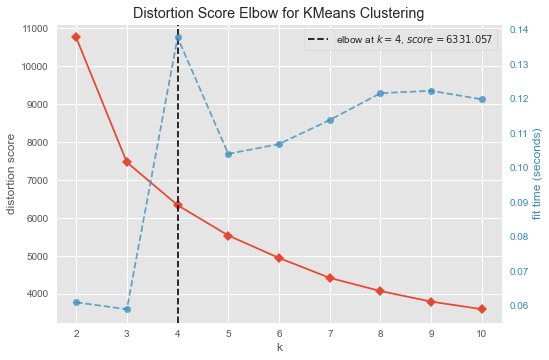

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [16]:
elbow = KElbowVisualizer(KMeans(), k=10)
elbow.fit(pca_df)
elbow.show()

#### The optimal number of clusters for the dataset is 4.

#### Now I cluster the dataset using Agglomerative Clustering (a type of hierarchical clustering) to generate a cluster prediction for each row in the PCA dataset. I will then connect those clusters directly to the original dataset so that I can conduct profiling in the future.

In [17]:
#Initiating the Agglomerative Clustering model 
ac = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
predictions = ac.fit_predict(pca_df)
pca_df["Clusters"] = predictions
orig_df["Clusters"]= predictions

#### With the clusters generated, now I will visualize the results in a 3D scatterplot.

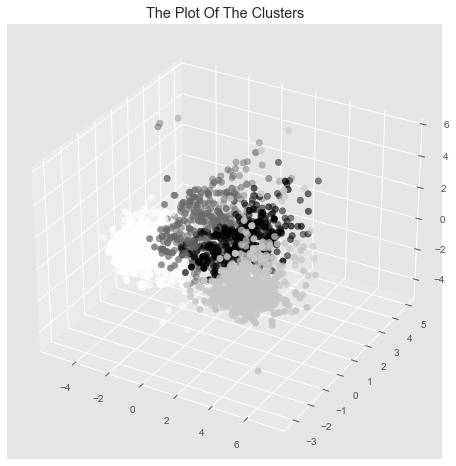

In [18]:
#Plotting the clusters
x = pca_df["col1"]
y = pca_df["col2"]
z = pca_df["col3"]
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=pca_df["Clusters"], marker='o')
ax.set_title("The Plot Of The Clusters")
plt.show()

## Profiling

#### With each row in the dataset placed into a cluster, I will begin profiling the results (determine the different characteristics of each cluster).

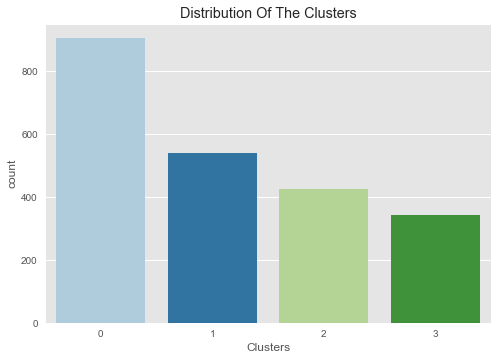

In [19]:
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c']
pl = sns.countplot(x=orig_df["Clusters"], palette=colors)
pl.set_title("Distribution Of The Clusters")
plt.show()

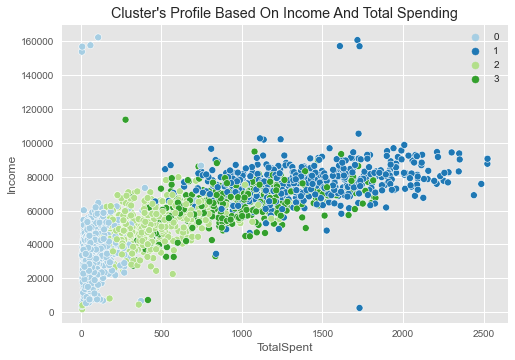

In [20]:
pl = sns.scatterplot(data = orig_df,x=orig_df["TotalSpent"], y=orig_df["Income"],hue=orig_df["Clusters"], palette= colors)
pl.set_title("Cluster's Profile Based On Income And Total Spending")
plt.legend()
plt.show()

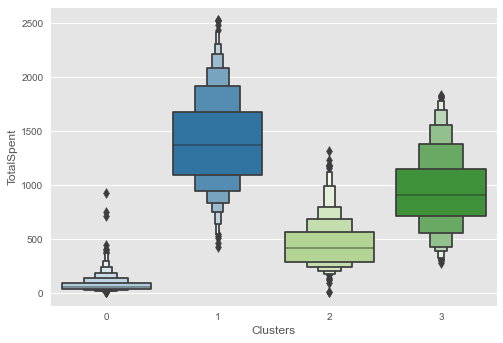

In [21]:
plt.figure()
pl=sns.boxenplot(x=orig_df["Clusters"], y=orig_df["TotalSpent"], palette=colors)
plt.show()

In [22]:
orig_df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,TotalSpent,Clusters
0,5524,1957,2,1,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,1617,1
1,2174,1954,2,1,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,27,0
2,4141,1965,2,2,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,776,3
3,6182,1984,2,2,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,53,0
4,5324,1981,4,2,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,422,3


#### Cluster 1 is our star customer group; They spend the most money at the store.

<Figure size 576x396 with 0 Axes>

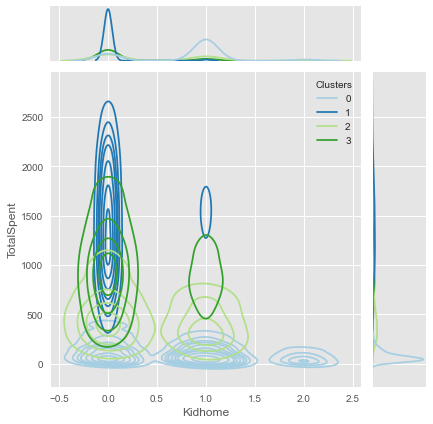

<Figure size 576x396 with 0 Axes>

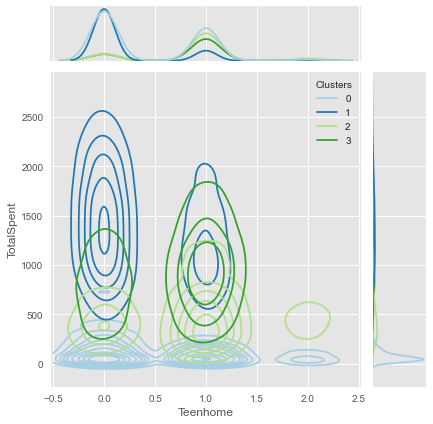

<Figure size 576x396 with 0 Axes>

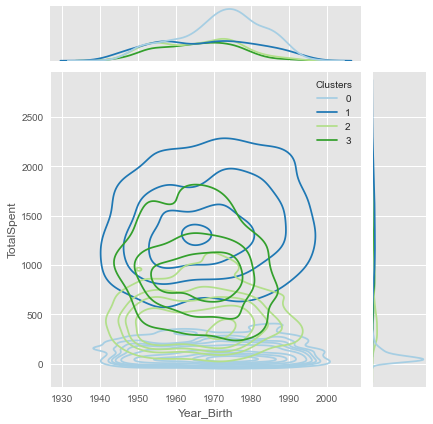

<Figure size 576x396 with 0 Axes>

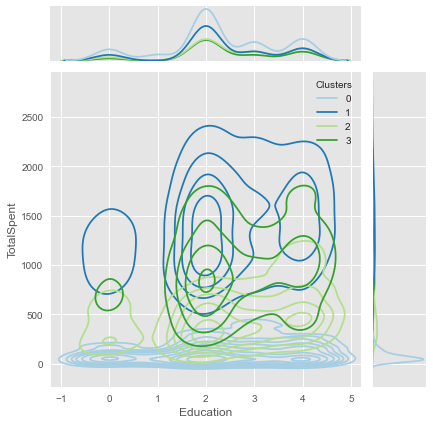

<Figure size 576x396 with 0 Axes>

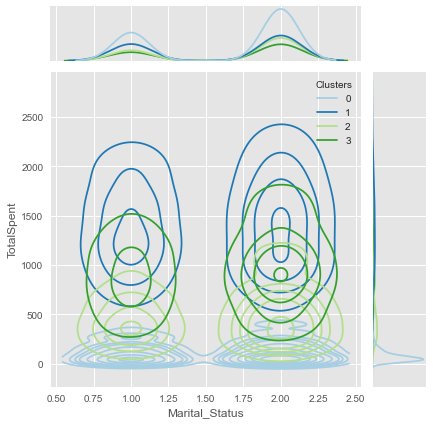

In [23]:
characteristics = [ "Kidhome","Teenhome", "Year_Birth", "Education", "Marital_Status"]

for i in characteristics:
    plt.figure()
    sns.jointplot(x=orig_df[i], y=orig_df["TotalSpent"], hue =orig_df["Clusters"], kind="kde", palette=colors)
    plt.show()

#### Cluster 0: 
* Most are parents
* Most are younger
* Wide range of educations
* Most are married

#### Cluster 1:
* Not parents
* Wide range of ages
* Most have high education
* Half are married

#### Cluster 2:
* Most are parents
* Most are older
* Most have high education
* Most are married

#### Cluster 3:
* Most are parents
* Most are older
* Most have high education
* Half are married

## Conclusion

#### Using unsupervised learning to segment customers, I was able to learn that individuals who are not parents and have high education are most likely to purchase products at the store. This group of people should be leveraged with future marketing campaigns to maximize profit.